---
title: Quick Introduction to Bootstrap
author: Eugene Scherba
date: April 1, 2023
---

# Data overview

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm as progress_bar

In [2]:
df = pd.read_csv("horse_kicks.csv")
df.set_index("Year", inplace=True)

In [3]:
df

,GC,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C14,C15
Year,,,,,,,,,,,,,,
1875,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1876,2,0,0,0,1,0,0,0,0,0,0,0,1,1
1877,2,0,0,0,0,0,1,1,0,0,1,0,2,0
1878,1,2,2,1,1,0,0,0,0,0,1,0,1,0
1879,0,0,0,1,1,2,2,0,1,0,0,2,1,0
1880,0,3,2,1,1,1,0,0,0,2,1,4,3,0
1881,1,0,0,2,1,0,0,1,0,1,0,0,0,0
1882,1,2,0,0,0,0,1,0,1,1,2,1,4,1
1883,0,0,1,2,0,1,2,1,0,1,0,3,0,0


The columns correspond to different cavalry regiment. We are interested in the distribution of events per year per regiment.

In [4]:
_values = df.values.ravel()

In [5]:
counts = pd.Series(_values).value_counts()

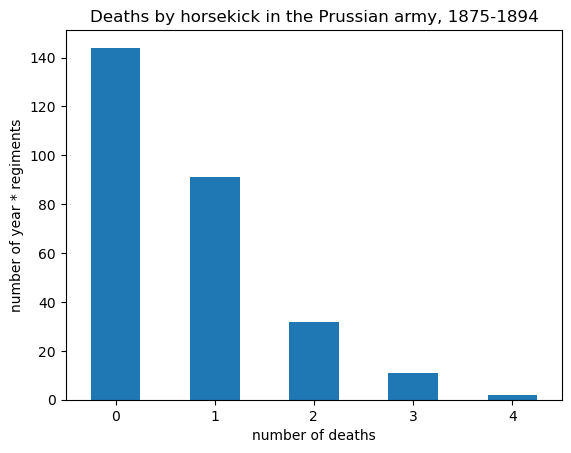

In [6]:
counts.plot.bar(
    rot=0,
    xlabel="number of deaths",
    ylabel="number of year * regiments",
    title="Deaths by horsekick in the Prussian army, 1875-1894");

# Poisson Modeling: Estimating Lambda

## Maximum Likelihood Estimate: Simple mean

Poisson distribution is a famous asymmetric distribution with only one parameter: mean (labmda). By contrast, Gausssian distribition has two parameters (mean and variance). Under Poisson, however, mean is the same parameter as variance.

While the Gaussian distribution is frequently used to model measurement uncertainty of real variables, Poisson distribution is used to model uncertainty of _counts of rare events_ (baseball home runs, frequency of all types of rare incidents, and so on).

In [7]:
lambda_hat = df.values.ravel().mean()

In [8]:
lambda_hat

0.7

In [9]:
fitted = pd.Series(
    poisson.pmf(counts.index, lambda_hat) * counts.sum(),
    index=counts.index)

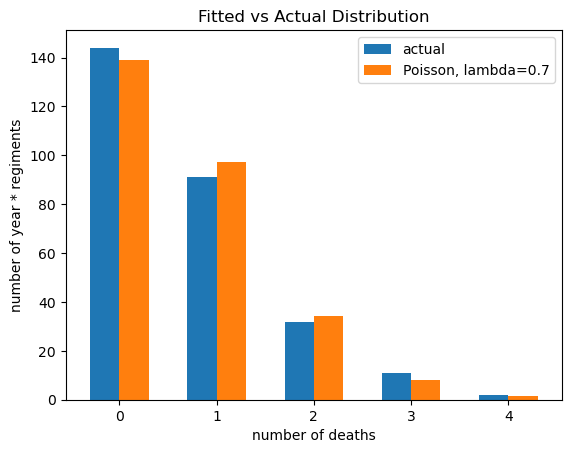

In [10]:
pd.DataFrame({
    "actual": counts,
    "Poisson, lambda=0.7": fitted,
}).plot.bar(
    rot=0,
    xlabel="number of deaths",
    ylabel="number of year * regiments",
    title="Fitted vs Actual Distribution", width=0.6);

This is useful because, for example, in case we find a regiment that had 5 kicks in a single yet, we could calculate the probability of that happening under Poisson distribution.

A skeptic may still be unhappy, however. "But wait," he says, "how do you know that your estimate of Lambda is correct? Afterall, everything here rests on that magical Lambda=0.7 which you derived from the data itself!"

# Estimating Uncertainty of Lambda-Hat

## Classical Boostrap: Discrete sampling with replacement

In [11]:
estimates = []

rng = np.random.default_rng(42)
for _ in progress_bar(range(300000)):
    values = rng.choice(_values, _values.size, replace=True)
    estimates.append(values.mean())

  0%|          | 0/300000 [00:00<?, ?it/s]

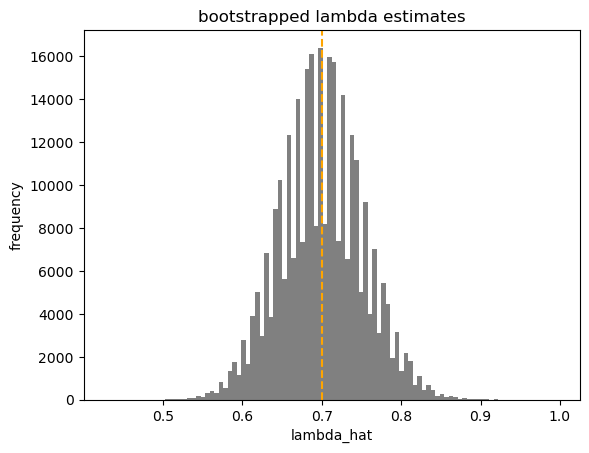

In [12]:
fig, ax = plt.subplots()
ax.hist(estimates, bins=100, color="grey");
ax.set_ylabel("frequency")
ax.set_xlabel("lambda_hat")
ax.set_title("bootstrapped lambda estimates")
ax.axvline(lambda_hat, ls="--", color="orange");

The jagged contour is a drawback of discrete sampling. There is likely here a "true" distribution that slightly higher than the solid bell but lower than the jagged one. Still, this is sufficient to infer that 95% bounds for Lambda-hat lie roughly between 0.6 and 0.8.

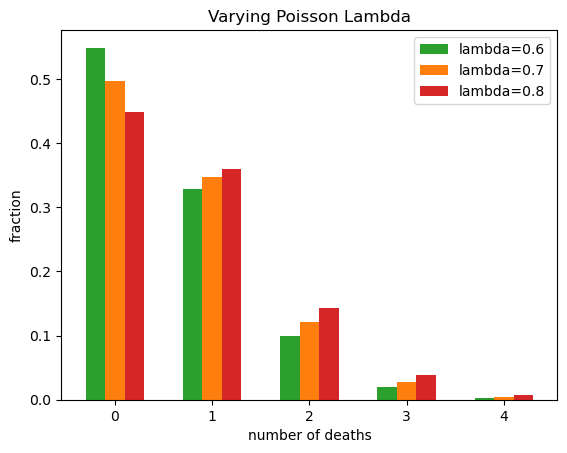

In [13]:
pd.DataFrame({
    "lambda=0.6": pd.Series(poisson.pmf(counts.index, 0.6), index=counts.index),
    "lambda=0.7": pd.Series(poisson.pmf(counts.index, 0.7), index=counts.index),
    "lambda=0.8": pd.Series(poisson.pmf(counts.index, 0.8), index=counts.index),
}).plot.bar(
    rot=0,
    xlabel="number of deaths",
    ylabel="fraction",
    title="Varying Poisson Lambda", width=0.6, color=["C2", "C1", "C3"]);

## Bayesian Bootstrap: Continuous sampling via Dirichlet prior

### Typical usage

In [14]:
estimates = []

alpha_scale = 1.
rng = np.random.default_rng(42)
for _ in progress_bar(range(300000)):
    num_samples = _values.size
    sample_weight = np.ones(num_samples)
    denom = sample_weight.sum()
    alpha = sample_weight * (num_samples * alpha_scale / denom)
    sample_weight = rng.dirichlet(alpha, size=1)[0]
    values = sample_weight * _values * denom
    estimates.append(values.mean())

  0%|          | 0/300000 [00:00<?, ?it/s]

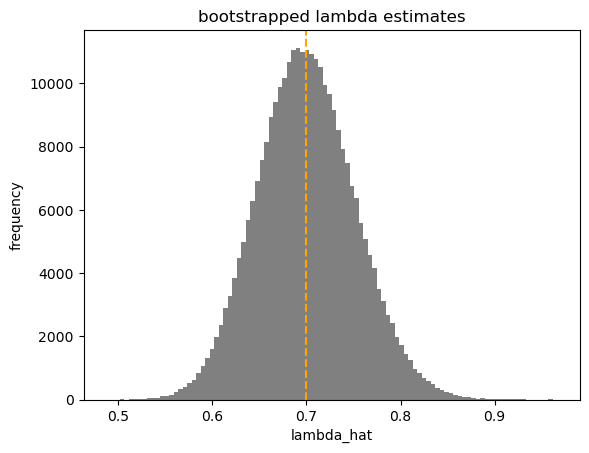

In [15]:
fig, ax = plt.subplots()
ax.hist(estimates, bins=100, color="grey");
ax.set_title("bootstrapped lambda estimates")
ax.set_ylabel("frequency")
ax.set_xlabel("lambda_hat")
ax.axvline(lambda_hat, ls="--", color="orange");

Impressively, Bayesian sampling gets rid of the jagged contour entirely.

### Modeling increased uncertainty

This can be achieved by decreasing alpha_scale parameter

In [16]:
estimates = []

alpha_scale = 0.025
rng = np.random.default_rng(42)
for _ in progress_bar(range(300000)):
    num_samples = _values.size
    sample_weight = np.ones(num_samples)
    denom = sample_weight.sum()
    alpha = sample_weight * (num_samples * alpha_scale / denom)
    sample_weight = rng.dirichlet(alpha, size=1)[0]
    values = sample_weight * _values * denom
    estimates.append(values.mean())

  0%|          | 0/300000 [00:00<?, ?it/s]

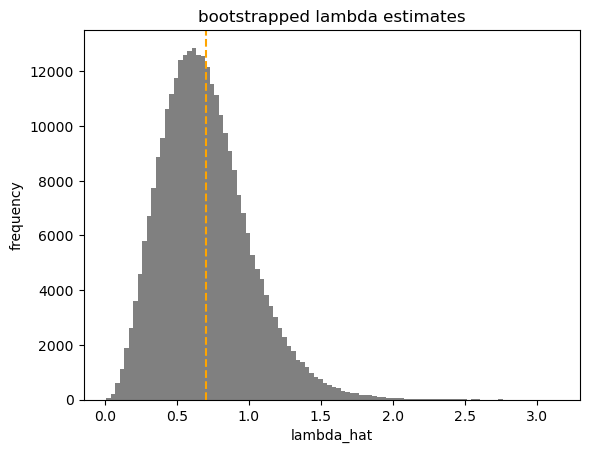

In [17]:
fig, ax = plt.subplots()
ax.hist(estimates, bins=100, color="grey");
ax.set_title("bootstrapped lambda estimates")
ax.set_ylabel("frequency")
ax.set_xlabel("lambda_hat")
ax.axvline(lambda_hat, ls="--", color="orange");

Lowering the alpha simulates higher sampling uncertainty. It is interesting to note that the bootstrap distribution becomes asymmetric. On the other hand, increasing the alpha simulates lower sampling uncertainty, and the bootstrap distribution remains symmetric, although becomes much more narrow (with higher kurtosis).